## Initiation

In [1]:
# To manipulate arrays
import numpy as np 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread
from skimage.morphology import dilation, disk
from scipy.ndimage import binary_fill_holes

# Image processing and filters
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import io, filters, data
import napari

# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths
import glob

# Functions

In [2]:
def detect_files(dir, filetype, string, not_in_string=None, search_subdirs=False):
    file_list = [] # list to store all matching files
    
    # iterate over all files and subdirectories in the given directory
    for item in os.scandir(dir):
        if item.is_file() and item.name.endswith(filetype) and string in item.name:
            if not_in_string is None or not_in_string not in item.name:
                file_list.append(item.path) # add to the list of matching files
        elif item.is_dir() and search_subdirs:
            # if search_subdirs flag is True and the item is a directory, search in it
            file_list.extend(detect_files(item.path, filetype, string, not_in_string, search_subdirs))
    
    return file_list

In [3]:
def my_transpose_list(ar, input_list):
    my_length = len(input_list)  # Should always be 6 = ['fov','f','z','y','x','ch']
    my_none_count = input_list.count('None')  # Get number of 'None' elements in current image
    my_expand_dim_list = tuple(-(np.arange(my_none_count)+1))
    my_count = len(input_list) - my_none_count
    output_list = []
    counter = my_count
    if my_count > 0: 
        for i in np.arange(my_length):
            if input_list[i] == 'None':
                output_list.append(counter)
                counter = counter + 1
            else:
                output_list.append(input_list[i])
    output_ar = np.expand_dims(ar,my_expand_dim_list)
    return np.transpose(output_ar, output_list)
input_list = [0,'None',3,2,'None',1]
my_croparray = my_transpose_list(np.zeros([10,11,12,13]),input_list)
my_croparray.shape

(10, 1, 13, 12, 1, 11)

In [4]:
# Functions for finding nuclei and creating rings around it 
def create_ring(binary_image, width):
    filled_image = dilation(binary_fill_holes(binary_image), footprint=disk(5))
    dilated_image = dilation(filled_image, footprint=disk(width))
    ring_image = dilated_image & ~filled_image
    return ring_image

def apply_threshold(image, threshold_factor):
    thresh = threshold_otsu(image)
    bw = closing(image > thresh * threshold_factor, square(3))
    return bw

def remove_border_artifacts(binary_image):
    return clear_border(binary_image)

def create_labeled_image(binary_image):
    return label(binary_image)

def filter_regions_by_area(label_image, min_area):
    filtered_label_image = np.zeros_like(label_image)
    for region in regionprops(label_image):
        if region.area >= min_area:
            filtered_label_image[label_image == region.label] = region.label
    return filtered_label_image

def create_label_overlay(image, label_image):
    return label2rgb(label_image, image=image, bg_label=0)

def create_ring_label_image(label_image, ring_width):
    ring_label_image = np.zeros_like(label_image)
    for label_value in np.unique(label_image):
        if label_value == 0:  # Skip the background label
            continue
        binary_mask = (label_image == label_value)
        ring_image = create_ring(binary_mask, width=ring_width)
        ring_label_image[ring_image] = label_value
    return ring_label_image  

def display_image(image, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def average_intensity_and_center_of_mass(label_image, original_image):
    region_info = {}

    for region in regionprops(label_image):
        label_value = region.label
        mask = (label_image == label_value)
        intensity_values = original_image[mask]
        mean_intensity = np.mean(intensity_values)

        # Calculate center of mass for the region
        center_of_mass = region.centroid

        region_info[label_value] = {
            'average_intensity': mean_intensity,
            'center_of_mass': center_of_mass
        }

    return region_info

In [386]:
def pivot_dataframe(df):
    """
    Pivot the DataFrame based on 'channel' and 'mask' columns, expanding the DataFrame to include 
    all combinations of these two columns for each 'frame' and 'label'. Flattens the multi-level 
    columns into a single level.
    
    Parameters:
    - df: pandas DataFrame with 'frame', 'label', 'average_intensity', 'center_of_mass_x', 
          'center_of_mass_y', 'mask', and 'channel' columns.
    
    Returns:
    - pivoted_df: pandas DataFrame after pivoting.
    """
    
    # Pivot the DataFrame
    pivoted_df = df.pivot_table(index=['frame', 'label'],
                                columns=['channel', 'mask'],
                                values=['average_intensity', 'center_of_mass_x', 'center_of_mass_y'],
                                aggfunc='mean')  # Use 'mean', 'sum', 'first', etc., as needed

    # Flatten the multi-level column index
    pivoted_df.columns = ['_'.join(str(col) for col in cols if col) for cols in pivoted_df.columns]

    # Reset the index to turn it back into columns
    pivoted_df.reset_index(inplace=True)
    
    return pivoted_df

In [379]:
def process_frames(img_6D, ch0_heading,ch1_heading, threshold_factor, min_area, ring_width, output_images=False):
    num_frames = img_6D.shape[1]
    all_regions_data = []
    all_regions_data_ch1 = []
    label_arrays = []
    ring_arrays = []

    for frame in range(num_frames):
        image = img_6D[0, frame, 0, :, :, 0]  # use this for making masks
        image_ch1 = img_6D[0, frame, 0, :, :, 1] # use this for other channels to make mask measurement in...could continue for image_ch2, image_ch3, ....

        bw = apply_threshold(image, threshold_factor)
        cleared = remove_border_artifacts(binary_fill_holes(bw)) # remove cells on border and fill holes, e.g. nucleoli
        label_image = create_labeled_image(cleared)
        filtered_label_image = filter_regions_by_area(label_image, min_area)
        image_label_overlay = create_label_overlay(image, filtered_label_image)

        ring_label_image = create_ring_label_image(filtered_label_image, ring_width)
        image_label_overlay_ring = create_label_overlay(image, ring_label_image)

        # if output_images:
        #     display_image(image_label_overlay)
        #     display_image(image_label_overlay_ring)

        region_data = average_intensity_and_center_of_mass(filtered_label_image, image)
        region_data_ring = average_intensity_and_center_of_mass(ring_label_image, image)
        region_data_ch1 = average_intensity_and_center_of_mass(filtered_label_image, image_ch1)
        region_data_ring_ch1 = average_intensity_and_center_of_mass(ring_label_image, image_ch1)
        
# For original channel 0:
        for label_value, data in region_data.items():
            all_regions_data.append({
                'frame': frame,
                'label': label_value,
                'average_intensity': data['average_intensity'],
                'center_of_mass_x': data['center_of_mass'][0],
                'center_of_mass_y': data['center_of_mass'][1],
                'mask': 'nucleus'
            })

        for label_value, data in region_data_ring.items():
            all_regions_data.append({
                'frame': frame,
                'label': label_value,
                'average_intensity': data['average_intensity'],
                'center_of_mass_x': data['center_of_mass'][0],
                'center_of_mass_y': data['center_of_mass'][1],
                'mask': 'cytoplasm'
            })

# For original channel 1:
        for label_value, data in region_data_ch1.items():
            all_regions_data_ch1.append({
                'frame': frame,
                'label': label_value,
                'average_intensity': data['average_intensity'],
                'center_of_mass_x': data['center_of_mass'][0],
                'center_of_mass_y': data['center_of_mass'][1],
                'mask': 'nucleus'
            })

        for label_value, data in region_data_ring_ch1.items():
            all_regions_data_ch1.append({
                'frame': frame,
                'label': label_value,
                'average_intensity': data['average_intensity'],
                'center_of_mass_x': data['center_of_mass'][0],
                'center_of_mass_y': data['center_of_mass'][1],
                'mask': 'cytoplasm'
            })            

        label_arrays.append(filtered_label_image)
        ring_arrays.append(ring_label_image)

    df = pd.DataFrame(all_regions_data)
    df['channel']='ch0'
    df_ch1 = pd.DataFrame(all_regions_data_ch1)
    df_ch1['channel']='ch1'
    df_out=pd.concat([df,df_ch1])
    return df_out, np.stack(label_arrays), np.stack(ring_arrays)

In [485]:
def display_with_napari(img_6D, label_arrays, ring_arrays):
    viewer = napari.Viewer()

    # Stack original images into a 3D array (frames, height, width)
    original_images = img_6D[0, :, 0, :, :, 0]
    original_images_ch1 = img_6D[0, :, 0, :, :, 1]

    min0, max0,min1,max1=np.quantile(original_images,0.01),np.quantile(original_images,0.999),np.quantile(original_images_ch1,0.01),np.quantile(original_images_ch1,0.999)

    # Add the original images ch0 to the Napari viewer
    viewer.add_image(original_images, name='Original Images', scale=(1, 1, 1),colormap='magenta', blending='additive', contrast_limits = [min0,max0])

    # Add the original images ch1 to the Napari viewer
    viewer.add_image(original_images_ch1, name='Original Images', scale=(1, 1, 1),colormap='green', blending='additive', contrast_limits=[min1,max1])

    # Add the label arrays as a label layer
    viewer.add_labels(label_arrays, name='Label Arrays', scale=(1, 1, 1))

    # Add the ring arrays as a separate label layer
    viewer.add_labels(ring_arrays, name='Ring Arrays', scale=(1, 1, 1))

    # Start the Napari GUI event loop
    napari.run()


In [368]:
def convert_to_rgb(image, rgb_pattern, int_range):
    """
    Convert an image with 1, 2, or 3 color channels to an RGB image based on a specified pattern.
    
    :param image: A numpy array of shape (dimx, dimy, n) where n is 1, 2, or 3
    :param rgb_pattern: A string indicating RGB channel mapping ('001', '010', '100' for single channel).
                        For multiple channels, each character should be '0', '1', or '2'.
    :param int_range: A list of lists specifying intensity ranges for each channel.
    :return: A numpy array representing an RGB image.
    """
    if len(image.shape) != 3 or image.shape[2] not in [1, 2, 3]:
        raise ValueError("Image must have 1, 2 or 3 color channels")

    if len(rgb_pattern) != 3 or not all(ch in '012' for ch in rgb_pattern):
        raise ValueError("rgb_pattern must be a string of length 3 with characters '0', '1', or '2'")

    if len(int_range) != image.shape[2]:
        raise ValueError("int_range must have the same number of elements as there are color channels in the image")

    dimx, dimy, _ = image.shape
    rgb_image = np.zeros((dimx, dimy, 3), dtype=image.dtype)

    for i, channel in enumerate(rgb_pattern):
        if int(channel) < image.shape[2]:
            channel_image = image[:, :, int(channel)]
            min_val, max_val = int_range[int(channel)]
            # Normalize and scale the channel based on the intensity range
            norm_image = np.clip(channel_image, min_val, max_val)
            norm_image = (norm_image - min_val) / (max_val - min_val)
            rgb_image[:, :, i] = norm_image*255
        else:
            rgb_image[:, :, i] = 0

    return rgb_image

# Example usage:
# Assuming 'my_image' is your numpy array
# int_range = [[0, 255], [0, 255], [0, 255]]  # Example intensity range for each channel
# rgb_image = convert_to_rgb(my_image, '010', int_range)

# To display the image
# plt.imshow(rgb_image)
# plt.show()


In [ ]:
def remove_rows_if_less_than(df, column, N):
    """
    Remove rows from the DataFrame where the number of occurrences 
    of the value in the specified column is less than N.

    Parameters:
    - df: pandas DataFrame
    - column: the column to check the value occurrence
    - N: threshold number of occurrences

    Returns:
    - pandas DataFrame after removal of rows
    """
    value_counts = df[column].value_counts()
    to_remove = value_counts[value_counts < N].index
    df_filtered = df[~df[column].isin(to_remove)]
    return df_filtered

# Example usage
# df = pd.read_csv('path_to_your_file.csv')  # Load your DataFrame
# result_df = remove_rows_if_less_than(df, 'your_column_name', N)

In [517]:
def transform_dataframe(df):
    # Stage 1: Handle 'cytoplasm' and 'nucleus'
    df_cyto = df.filter(like='_cytoplasm').rename(lambda x: x.replace('_cytoplasm', ''), axis=1)
    df_cyto['mask'] = 'cytoplasm'

    df_nucleus = df.filter(like='_nucleus').rename(lambda x: x.replace('_nucleus', ''), axis=1)
    df_nucleus['mask'] = 'nucleus'

    # Combine common columns for concatenation
    common_columns = df[['frame', 'label', 'nuclei', 'file']]
    df_cyto = pd.concat([common_columns, df_cyto], axis=1)
    df_nucleus = pd.concat([common_columns, df_nucleus], axis=1)
    
    # Concatenating the melted DataFrames
    df_melted = pd.concat([df_cyto, df_nucleus])

    # Stage 2: Handle 'ch0' and 'ch1'
    df_ch0 = df_melted.filter(like='_ch0').rename(lambda x: x.replace('_ch0', ''), axis=1)
    df_ch0['channel'] = 'ch0'

    df_ch1 = df_melted.filter(like='_ch1').rename(lambda x: x.replace('_ch1', ''), axis=1)
    df_ch1['channel'] = 'ch1'

    # Combine common columns again for concatenation
    common_columns_stage2 = df_melted[['frame', 'label', 'nuclei', 'file', 'mask']]
    df_ch0 = pd.concat([common_columns_stage2, df_ch0], axis=1)
    df_ch1 = pd.concat([common_columns_stage2, df_ch1], axis=1)
    
    # Concatenating the melted DataFrames
    final_df = pd.concat([df_ch0, df_ch1])

    # Drop NaN columns (if any) and reset index
    final_df.dropna(axis=1, how='all', inplace=True)
    final_df.reset_index(drop=True, inplace=True)

    return final_df

# Example usage:
# Assuming df_rep1 is your original DataFrame
# transformed_df_rep1 = transform_dataframe(df_rep1)

# Read in files and process one video at a time

In [642]:
# Step 1: get a list of all the files in temporal order that correspond to a single video
position_n = 7 # position; one video per position will be made
dir = r'Z:\SharedInternal\Scott\TSA Timecourse and FRAP'
frame_num = len(glob.glob(os.path.join(dir,'*full*Position '+str(position_n)+'_*C0*tif'))) #determine number of timepoints
myfiles_C0 = [glob.glob(os.path.join(dir,'*full*Position '+str(position_n)+'_*T'+to_two_digits(i)+'_*C0*tif')) for i in np.arange(frame_num)]
myfiles_C1 = [glob.glob(os.path.join(dir,'*full*Position '+str(position_n)+'_*T'+to_two_digits(i)+'_*C1*tif')) for i in np.arange(frame_num)]

In [643]:
# Step 2: Read in images for video
ch0 = np.array([imread(i[0]) for i in myfiles_C0])
ch1 = np.array([imread(i[0]) for i in myfiles_C1])
all_vids=np.array([ch1,ch0])
all_vids.shape

(2, 25, 17, 896, 600)

In [644]:
# Step 3: Transpose video into crop_array expected 6D format with shape (fov, f, z, y, x, ch)
img_6D = my_transpose_list(all_vids.data,['None',1,2,3,4,0]) 
img_6D.shape, all_vids.shape

((1, 25, 17, 896, 600, 2), (2, 25, 17, 896, 600))

In [645]:
# Step 4: Max projection on both channels:
start_slice = 0
stop_slice =img_6D.shape[2]
projection_axis = 2 # z-projection of slices
maxp = np.expand_dims(np.max(img_6D[:,:,start_slice:stop_slice,:,:,:].data, axis=projection_axis),axis=projection_axis)
maxp.shape, start_slice, stop_slice

((1, 25, 1, 896, 600, 2), 0, 17)

In [646]:
# Step 5: Background subtract and find nuclei and measure average intensity inside and in surrounding ring:

# Determine the channel intensity 1st and 99.9th percentile limits for background subtaction and plotting over nice ranges
min0, max0,min1,max1=np.quantile(maxp[0,:,0,:,:,0],0.01),np.quantile(maxp[0,:,0,:,:,0],0.999),np.quantile(maxp[0,:,0,:,:,1],0.01),np.quantile(maxp[0,:,0,:,:,1],0.999)
maxp_bg = np.transpose(np.array([(maxp[:,:,:,:,:,0]-min0),(maxp[:,:,:,:,:,1]-min1)]),(1,2,3,4,5,0)).clip(min=0) # subtract bg

# Detect and measure nuclei and cytoplasm intensities
df, label_arrays, ring_arrays = process_frames(maxp_bg,'H2B','H3K27ac',threshold_factor=1., min_area=5000, ring_width=6,output_images=True)

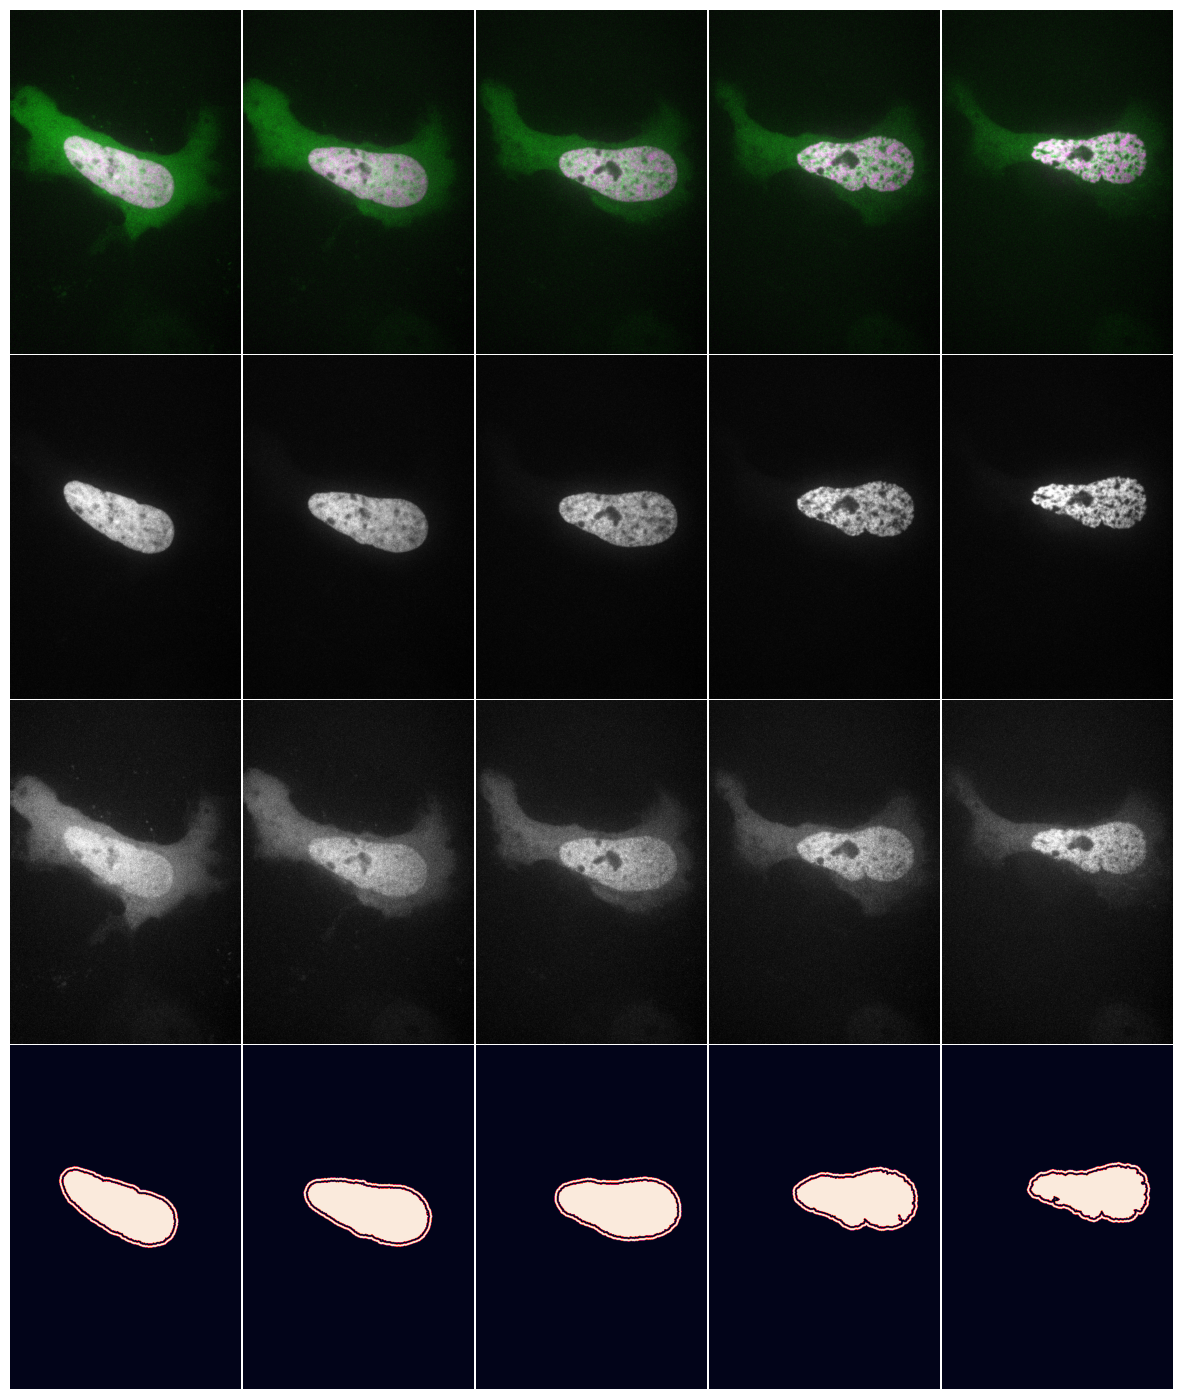

In [647]:
# Step 6: Make a summary set of plots for the experiment:
frames = np.arange(0,frame_num,6) # take every 4th frame

# Calculate the aspect ratio of a single image to set the figure size appropriately
image_aspect_ratio = maxp[0, 0, 0].shape[0] / maxp[0, 0, 0].shape[1]  # height / width
total_width = image_aspect_ratio * len(frames)

# Create a figure with a more appropriate width to reduce horizontal white space
fig, axs = plt.subplots(4, len(frames), figsize=(3*len(frames),3*4*image_aspect_ratio))

# Define the subplots
for idx, frame in enumerate(frames):
    axs[0, idx].imshow(convert_to_rgb(maxp[0, frame, 0], '010', [[min0, max0], [min1, max1]]))  # rgb
    axs[1, idx].imshow(convert_to_rgb(maxp[0, frame, 0], '000', [[min0, max0], [min1, max1]]))  # grayscale H2B
    axs[2, idx].imshow(convert_to_rgb(maxp[0, frame, 0], '111', [[min0, max0], [min1, max1]]))  # grayscale H3K27ac
    axs[3, idx].imshow(label_arrays[frame]+ring_arrays[frame])
    axs[0, idx].axis('off')
    axs[1, idx].axis('off')
    axs[2, idx].axis('off')
    axs[3, idx].axis('off')

# Adjust subplot parameters to give specified padding
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0)

# Before showing the plot, save it to a file with the desired DPI
plt.savefig(os.path.join(dir,'Tracked_Nuclei_Position_' +str(position_n)+'.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the figure

In [648]:
# Step 6.5: check all data with napari 
display_with_napari(maxp_bg, label_arrays, ring_arrays)

In [649]:
# Step 7: For TrackPy to track nuclei and give them a unique ID

# Modify the DataFrame to match the format expected by trackpy
pivoted_df = pivot_dataframe(df) # prepare for tracking
tracking_df = pivoted_df.rename(columns={'center_of_mass_x_ch0_nucleus': 'x', 'center_of_mass_y_ch0_nucleus': 'y'})

# Set the search_range parameter for trackpy.link_df()
search_range = 20

# Link the regions across frames using trackpy.link_df()
linked_df = tp.link_df(tracking_df, search_range, memory=2)

# Add a new column to the DataFrame with the particle index assigned by trackpy
pivoted_df['nuclei'] = linked_df['particle']

pivoted_df.head()

Frame 24: 1 trajectories present.


,frame,label,average_intensity_ch0_cytoplasm,average_intensity_ch0_nucleus,average_intensity_ch1_cytoplasm,average_intensity_ch1_nucleus,center_of_mass_x_ch0_cytoplasm,center_of_mass_x_ch0_nucleus,center_of_mass_x_ch1_cytoplasm,center_of_mass_x_ch1_nucleus,center_of_mass_y_ch0_cytoplasm,center_of_mass_y_ch0_nucleus,center_of_mass_y_ch1_cytoplasm,center_of_mass_y_ch1_nucleus,nuclei
0,0,1,198.549408,1087.433681,425.028633,683.553780,421.593757,424.898759,421.593757,424.898759,283.356297,288.037849,283.356297,288.037849,0
1,1,1,189.999149,1045.085455,392.699426,653.165422,419.591364,423.671593,419.591364,423.671593,289.486280,295.470638,289.486280,295.470638,0
2,2,1,188.633929,1017.284406,379.507653,635.373999,417.142007,421.025008,417.142007,421.025008,295.046556,301.449312,295.046556,301.449312,0
3,3,1,185.551644,1013.571924,362.041357,615.563965,414.404242,418.160660,414.404242,418.160660,300.462990,306.465264,300.462990,306.465264,0
4,4,1,180.296639,987.020274,346.952311,600.423459,418.652941,421.632981,418.652941,421.632981,309.391807,315.515056,309.391807,315.515056,0


In [650]:
# Export the tracking dataframe to a unique file corresponding to the position number in the original directory
pivoted_df.to_csv(os.path.join(dir,'Tracked_Nuclei_Position_' +str(position_n)+'.csv'), index=False)

# Combine data and plot

In [665]:
# Step 1: open all tif files you want to analyze (use a common super directory and all files in subdirectories will be found)
my_csvs = detect_files(r'Z:\SharedInternal\Scott\TSA Timecourse and FRAP', '.csv', 'Tracked_Nuclei_Position',not_in_string='puro', search_subdirs=True)
len(my_csvs), my_csvs

(7,
 ['Z:\\SharedInternal\\Scott\\TSA Timecourse and FRAP\\Tracked_Nuclei_Position_8.csv',
  'Z:\\SharedInternal\\Scott\\TSA Timecourse and FRAP\\Tracked_Nuclei_Position_10.csv',
  'Z:\\SharedInternal\\Scott\\TSA Timecourse and FRAP\\Tracked_Nuclei_Position_9.csv',
  'Z:\\SharedInternal\\Scott\\TSA Timecourse and FRAP\\Tracked_Nuclei_Position_11.csv',
  'Z:\\SharedInternal\\Scott\\TSA Timecourse and FRAP\\Tracked_Nuclei_Position_12.csv',
  'Z:\\SharedInternal\\Scott\\TSA Timecourse and FRAP\\Tracked_Nuclei_Position_14.csv',
  'Z:\\SharedInternal\\Scott\\TSA Timecourse and FRAP\\Tracked_Nuclei_Position_7.csv'])

In [652]:
# Step 2: open all files, remove tracks that are too short, and concatenate everything
min_track_length = 15
all_csvs = []
for file in my_csvs:
    temp = pd.read_csv(file)
    temp = remove_rows_if_less_than(temp,'nuclei',min_track_length) # Remove nuclei tracks if less than length 5 (or any number)
    temp['file'] = os.path.basename(file)
    all_csvs.append(temp)
df_rep1 = pd.concat(all_csvs)

In [653]:
df_rep1.head()

,frame,label,average_intensity_ch0_cytoplasm,average_intensity_ch0_nucleus,average_intensity_ch1_cytoplasm,average_intensity_ch1_nucleus,center_of_mass_x_ch0_cytoplasm,center_of_mass_x_ch0_nucleus,center_of_mass_x_ch1_cytoplasm,center_of_mass_x_ch1_nucleus,center_of_mass_y_ch0_cytoplasm,center_of_mass_y_ch0_nucleus,center_of_mass_y_ch1_cytoplasm,center_of_mass_y_ch1_nucleus,nuclei,file
0,0,1,256.263266,1572.048820,1434.268934,3442.538848,409.725571,406.621683,409.725571,406.621683,354.417654,359.014666,354.417654,359.014666,0,Tracked_Nuclei_Position_8.csv
1,1,1,250.256648,1511.465042,1380.219909,3330.176649,409.200315,405.299923,409.200315,405.299923,355.526417,359.161985,355.526417,359.161985,0,Tracked_Nuclei_Position_8.csv
2,2,1,248.275180,1529.774432,1323.244344,3290.005500,403.910675,401.402715,403.910675,401.402715,357.502598,363.197713,357.502598,363.197713,0,Tracked_Nuclei_Position_8.csv
3,3,1,250.408782,1512.424268,1289.717150,3257.733861,401.085170,399.096875,401.085170,399.096875,358.530240,363.764517,358.530240,363.764517,0,Tracked_Nuclei_Position_8.csv
4,4,1,251.254695,1532.674518,1283.756707,3284.235088,402.283199,399.872471,402.283199,399.872471,356.547451,361.447843,356.547451,361.447843,0,Tracked_Nuclei_Position_8.csv


In [654]:
# Measure quantities of interest
df_rep1['H3K27ac nuc/cyt (a.u.)'] = df_rep1['average_intensity_ch1_nucleus']/df_rep1['average_intensity_ch1_cytoplasm']
df_rep1['H2B nuc/cyt (a.u.)'] = df_rep1['average_intensity_ch0_nucleus']/df_rep1['average_intensity_ch0_cytoplasm'] 
df_rep1['H2B nuc. int. (a.u.)'] = df_rep1['average_intensity_ch0_nucleus']
df_rep1['time (min)'] = df_rep1['frame']*5

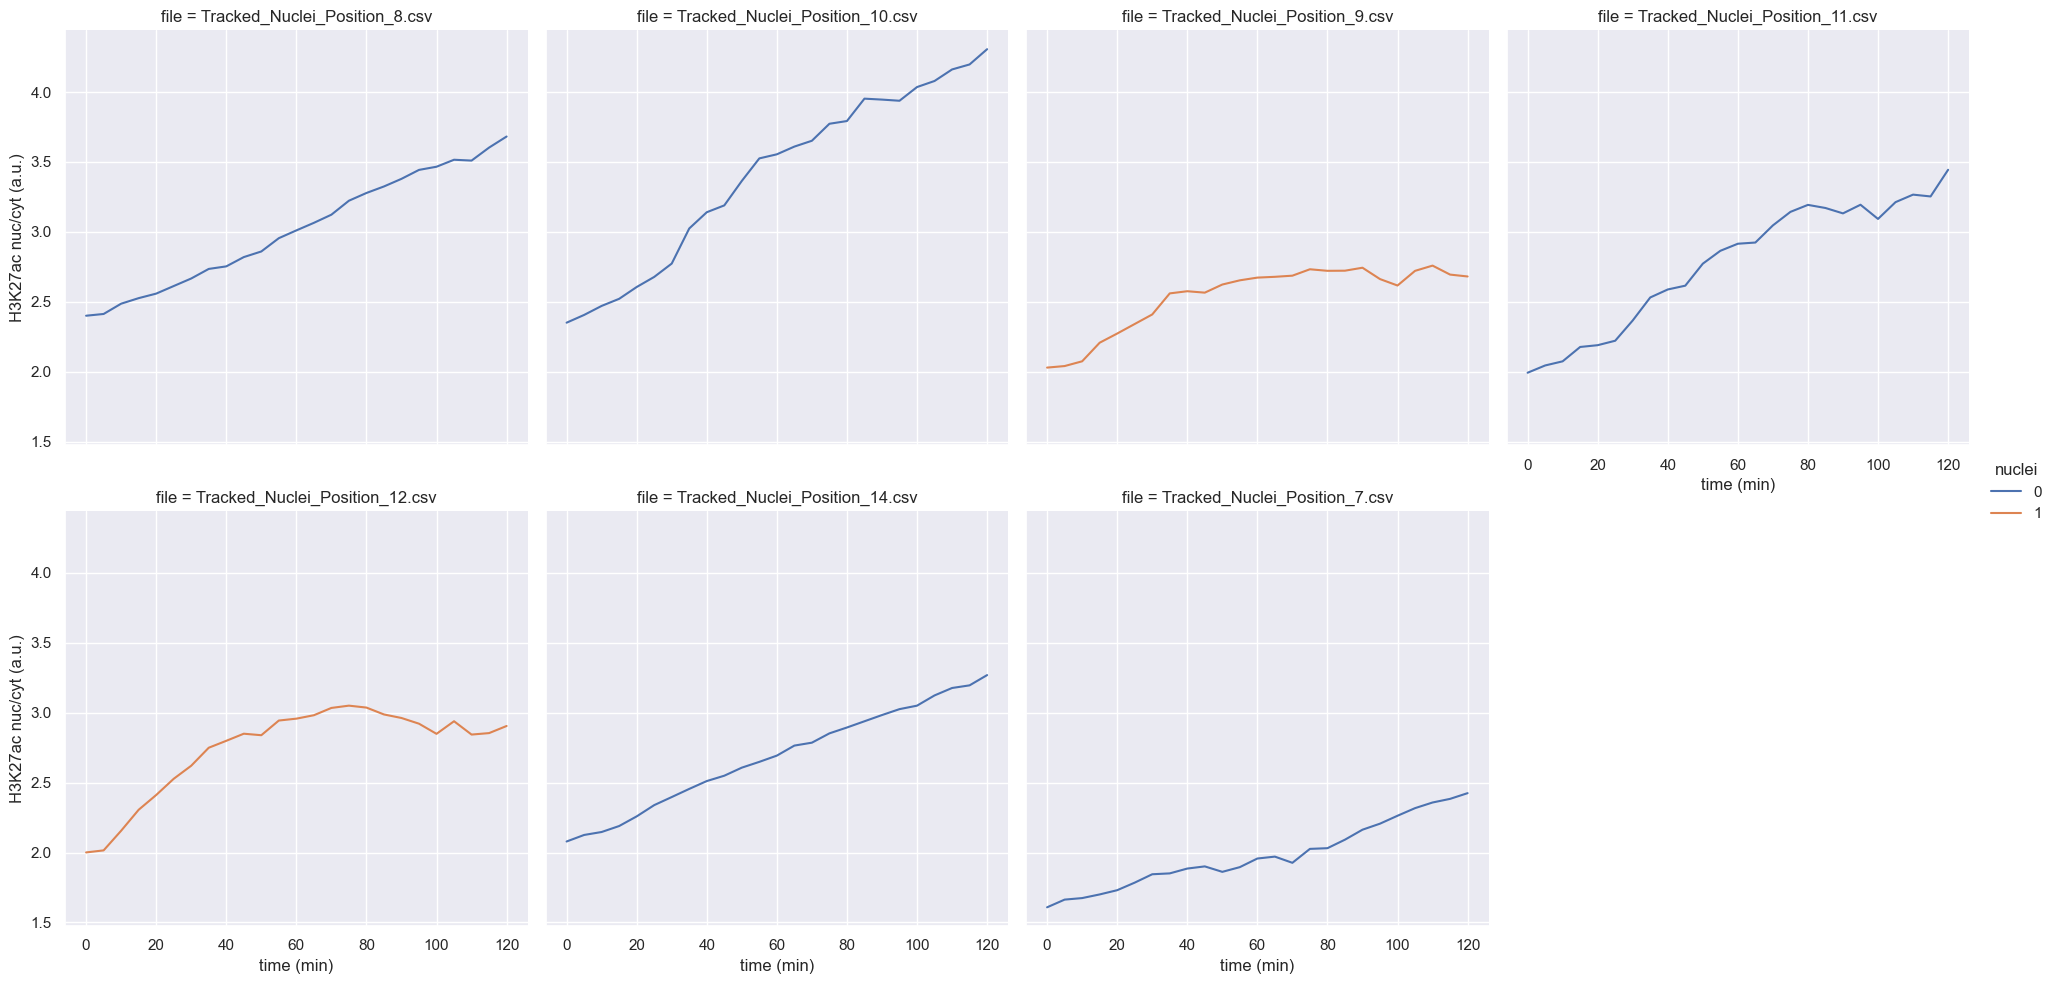

In [655]:
sns.relplot(data=df_rep1, x='time (min)', y='H3K27ac nuc/cyt (a.u.)', hue='nuclei',col='file',kind='line',col_wrap=4)

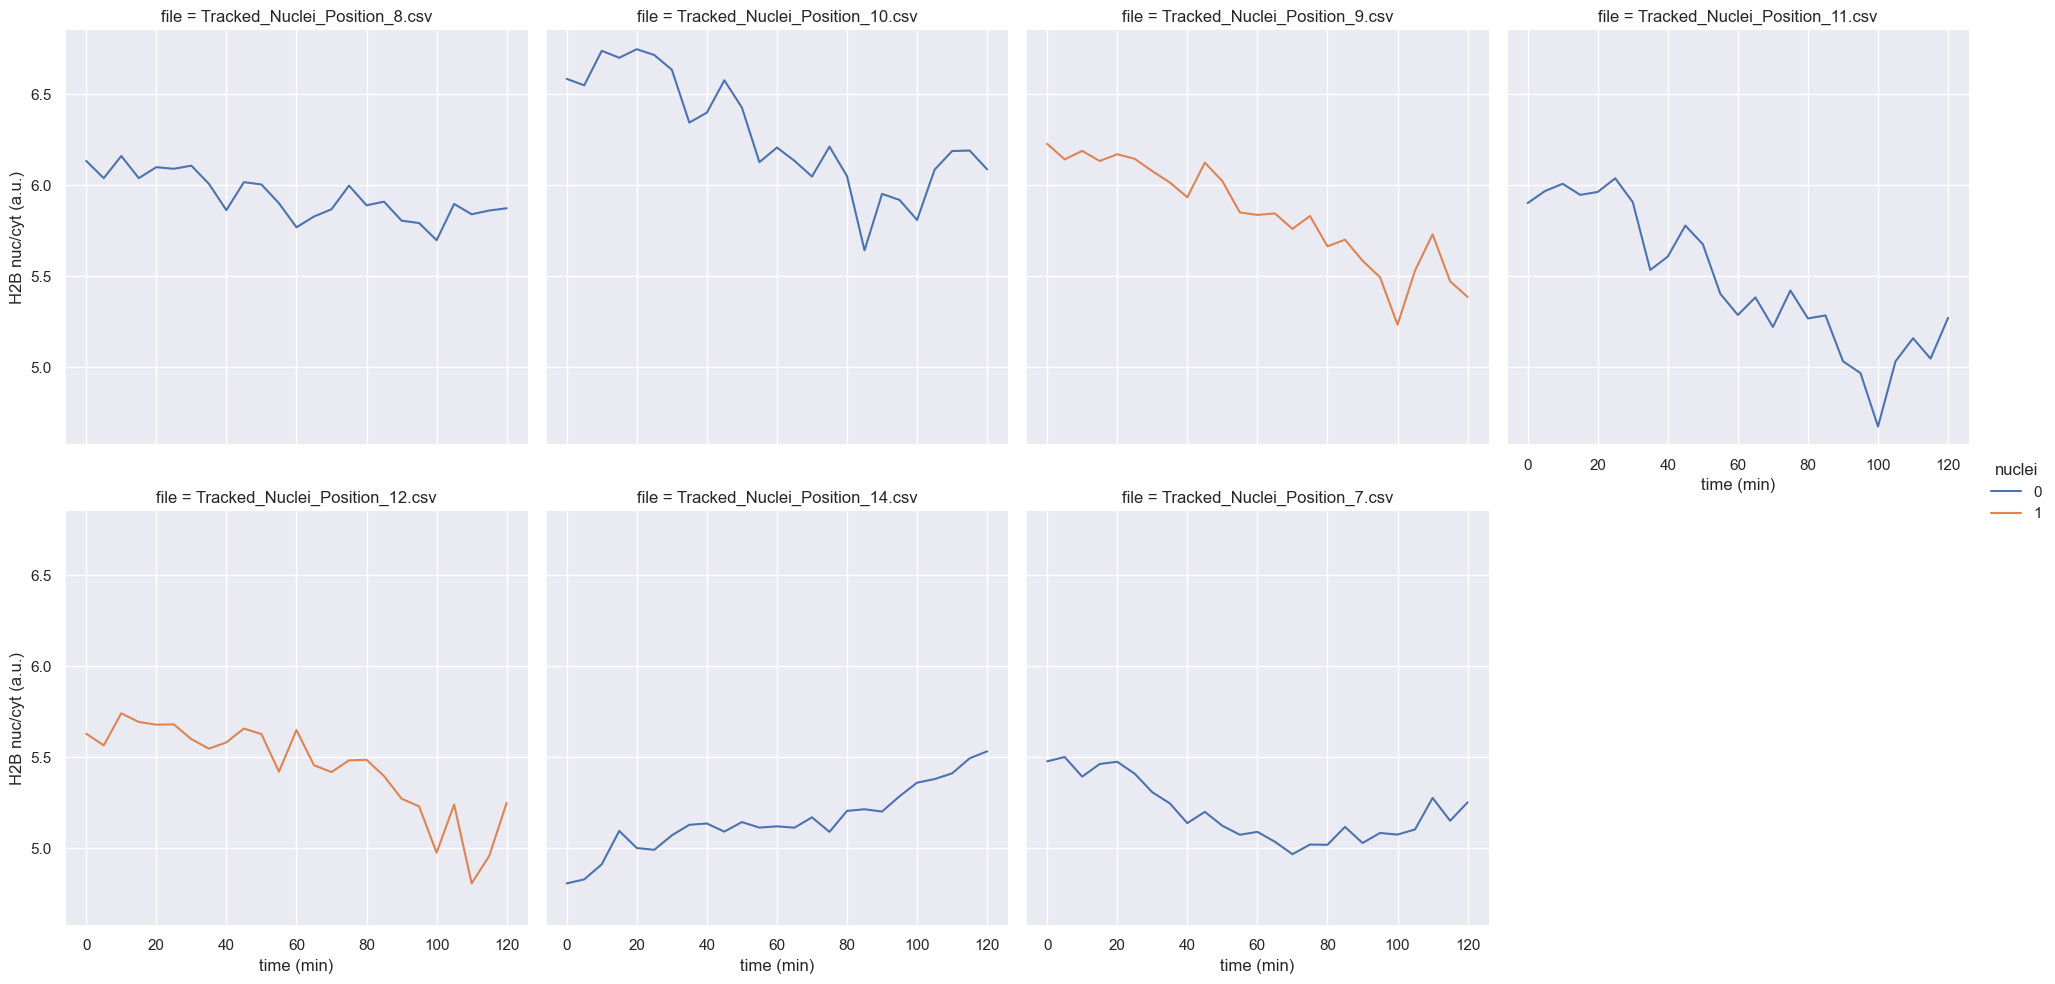

In [656]:
sns.relplot(data=df_rep1, x='time (min)', y='H2B nuc/cyt (a.u.)', hue='nuclei',col='file', kind='line',col_wrap=4)

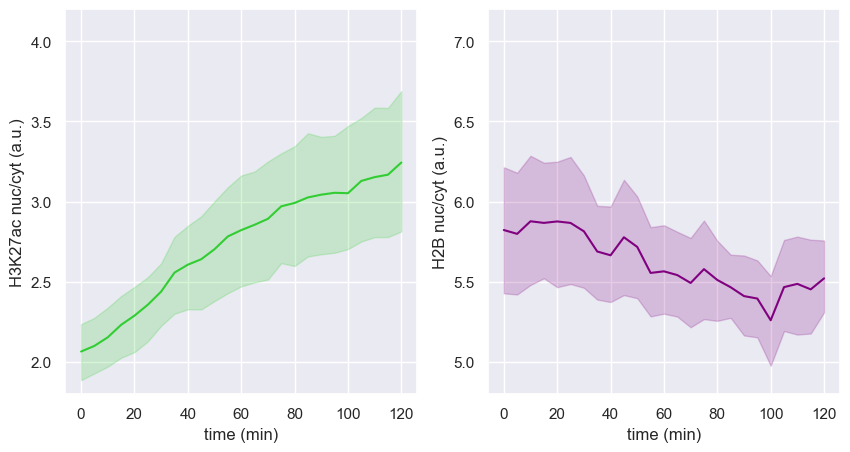

In [664]:
# Set up summary plot for paper
fig, axs = plt.subplots(1,2, figsize=(10,5))
# Define the subplots
sns.lineplot(data=df_rep1, x='time (min)', y='H3K27ac nuc/cyt (a.u.)',ax=axs[0],color='limegreen')
sns.lineplot(data=df_rep1, x='time (min)', y='H2B nuc/cyt (a.u.)', ax=axs[1],color='purple')
axs[0].set_ylim(1.8,4.2)
axs[1].set_ylim(4.8,7.2)
plt.show()

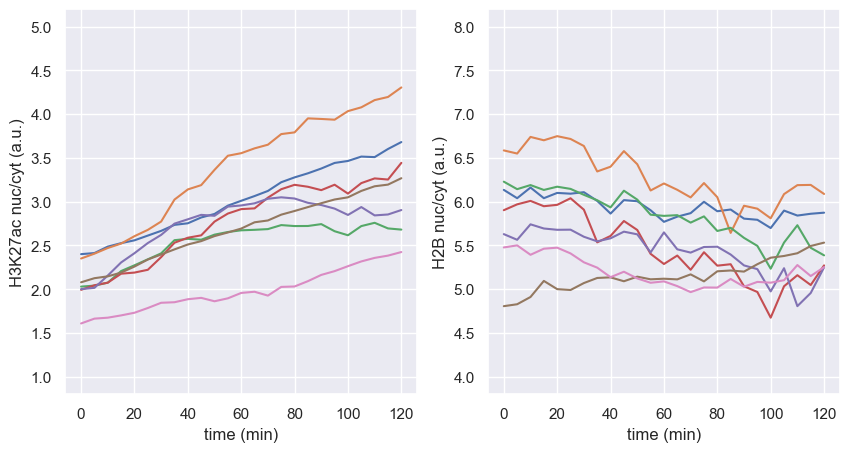

In [670]:
# Set up summary plot for paper
fig, axs = plt.subplots(1,2, figsize=(10,5))
# Define the subplots
sns.lineplot(data=df_rep1, x='time (min)', y='H3K27ac nuc/cyt (a.u.)',ax=axs[0],hue='file',legend=False)
sns.lineplot(data=df_rep1, x='time (min)', y='H2B nuc/cyt (a.u.)', ax=axs[1],hue='file',legend=False)
axs[0].set_ylim(.8,5.2)
axs[1].set_ylim(3.8,8.2)
plt.show()